In [1]:
import numpy as np
import pandas as pd


from sklearn.metrics import f1_score, roc_auc_score, log_loss, precision_score, classification_report, precision_recall_curve, confusion_matrix, roc_curve
import itertools

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
"""sklearn.linear_model.LogisticRegression(penalty='elasticnet', random_state=11, solver='saga')"""
"""sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=20, min_samples_split=4, min_samples_leaf=3, max_depth=5, random_state=11)"""
"""sklearn.ensemble.BaggingClassifier(n_estimators=20, random_state=11)"""
"""sklearn.ensemble.RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=5, min_samples_split=4, min_samples_leaf=3, random_state=11)"""

"sklearn.ensemble.RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=5, min_samples_split=4, min_samples_leaf=3, random_state=11)"

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, label = ''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    print(label)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def plot_roc_precision_curves(y_test, y_score, labels = '', curve_type = True):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    lw = 1.8
    if labels != '':
        p, r = [], []
        for row, y_score_row in enumerate(y_score):
            if curve_type :
                fpr_current, tpr_current, thresholds_ = roc_curve(y_test, y_score_row, pos_label=1)
                p_current = fpr_current
                r_current = tpr_current
            else:
                precision_current, recall_current, thresholds_ = precision_recall_curve(y_test, y_score_row, pos_label=1)
                p_current = recall_current
                r_current = precision_current
            p.append(p_current)
            r.append(r_current)
        for indx, (p_i, r_i) in enumerate(zip(p,r)):
            plt.plot(p_i, r_i, lw=lw, label=labels[indx])
    else:
        if curve_type :
            fpr, tpr, thresholds_ = roc_curve(y_test, y_score_row, pos_label=1)
            p = fpr
            r = tpr
        else:
            precision, recall, thresholds_ = precision_recall_curve(y_test, y_score_row, pos_label=1)
            p = precision
            r = recall
        plt.plot(p, r, lw=lw, label='ROC curve ')
    
    if curve_type:
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
    else:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall curve')
    #plt.savefig("ROC.png")
    plt.legend()
    plt.show()

## Урок 3. Связь бизнес-показателей и DS-метрик

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [4]:
df = pd.read_csv('train_case2.csv', ';')

Разделим наши данные на тренировочную и тестовую выборки

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], test_size = 0.3, random_state=11)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [7]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.69532927,  0.07881025, -0.63999752, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.30502285, -1.01474335, -1.67635863, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.33960685,  1.29386981,  1.43272471, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.16704814,  0.68634003,  0.25818212, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.21955179, -0.52871953, -0.29454381, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.35059599,  0.92935194, -1.19272344, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификаторы и запустим кросс-валидацию для каждого классификатора

### LogisticRegression

In [8]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=11)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score for LogisticRegression is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_lr = classifier.predict_proba(X_test)[:, 1]

CV score for LogisticRegression is 0.7834859125238662+-0.009240533053060836


### GradientBoostingClassifier

In [9]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.05, n_estimators=30, min_samples_split=4, min_samples_leaf=3, max_depth=5, random_state=11)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score for GradientBoostingClassifier is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_gbc = classifier.predict_proba(X_test)[:, 1]

CV score for GradientBoostingClassifier is 0.8003864957555172+-0.009963305914694383


### BaggingClassifier

In [10]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', BaggingClassifier(n_estimators=30, random_state=11)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score for BaggingClassifier is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_bc = classifier.predict_proba(X_test)[:, 1]

CV score for BaggingClassifier is 0.7615842321874334+-0.009214522583524995


### RandomForestClassifier

In [11]:

classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=7, min_samples_split=4, 
                                          min_samples_leaf=3, random_state=11)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score for RandomForestClassifier is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_rfc = classifier.predict_proba(X_test)[:, 1]

CV score for RandomForestClassifier is 0.7985568559937354+-0.010561770617419202


In [12]:
y_score = np.array((y_score_lr, y_score_gbc, y_score_bc, y_score_rfc))

In [13]:
labels = ['LogisticRegression', 'GradientBoostingClassifier', 'BaggingClassifier', 'RandomForestClassifier']

#### Посчитаем precision/recall/f_score

In [14]:
b=1
ix = []
data = []
for indx, y_score_row in enumerate(y_score):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_row)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix.append(np.argmax(fscore))
    data.append([thresholds[ix[indx]], fscore[ix[indx]], precision[ix[indx]], recall[ix[indx]]])
#заплатка
data = np.array((data))

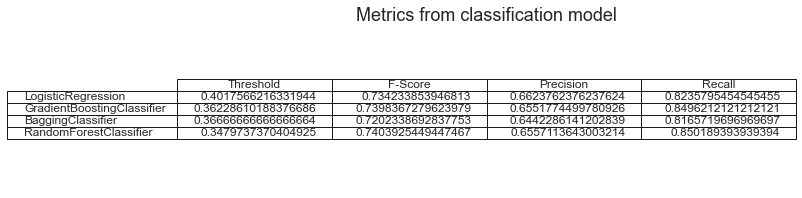

In [22]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [12, 3]

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

columns = ['Threshold', 'F-Score', 'Precision', 'Recall']
rows = labels
ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center', fontsize=16)
plt.title('Metrics from classification model')
fig.tight_layout()
plt.show()

#### Нарисуем roc auc кривые

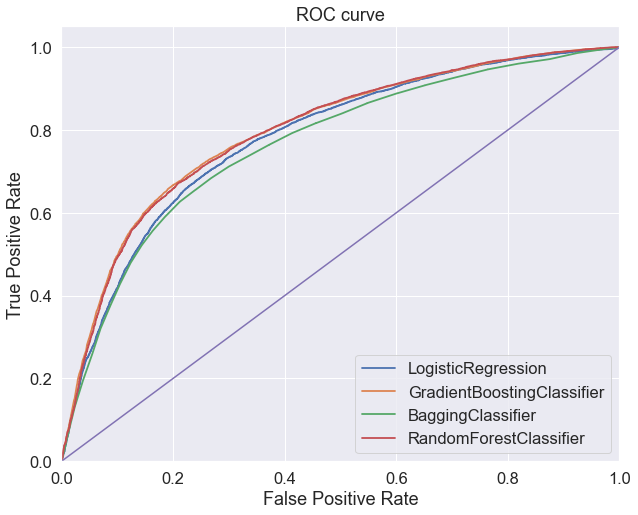

In [16]:
plot_roc_precision_curves(y_test, y_score, labels)

#### И precision recall кривые

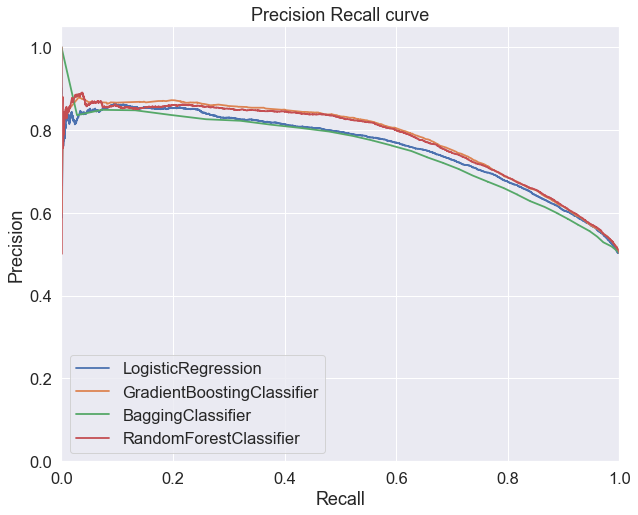

In [17]:
plot_roc_precision_curves(y_test, y_score, labels, curve_type = False)

##### к пункту 5 ДЗ
явно лучше выглядят алгоритмы RandomForestClassifier и GradientBoostingClassifier, но по кривым нельзя сказать однозначно. Слишком схожими по качеству они получились. Да и несмотря на то что для несбалансированной выборки лучше должна показывать результат precision recall кривая, но для текущих данных большой разницы не заметно. Так как классы хорошо сбалансированы.

In [18]:
df.loc[df['cardio']==0, 'cardio'].count()/df.loc[df['cardio']==1, 'cardio'].count()

1.0012007204322593

In [19]:
for indx, y_score_i in enumerate(y_score):
    print(labels[indx])
    print("roc auc score: {:f}".format(roc_auc_score(y_true=y_test, y_score=y_score_i)))
    print("log loss score: {:f}".format(log_loss(y_true=y_test, y_pred=y_score_i)))

LogisticRegression
roc auc score: 0.780232
log loss score: 0.583739
GradientBoostingClassifier
roc auc score: 0.797408
log loss score: 0.555433
BaggingClassifier
roc auc score: 0.764936
log loss score: 0.772443
RandomForestClassifier
roc auc score: 0.795578
log loss score: 0.551063


#### Матрицы ошибок

LogisticRegression
Confusion matrix, without normalization
[[6007 4433]
 [1864 8696]]


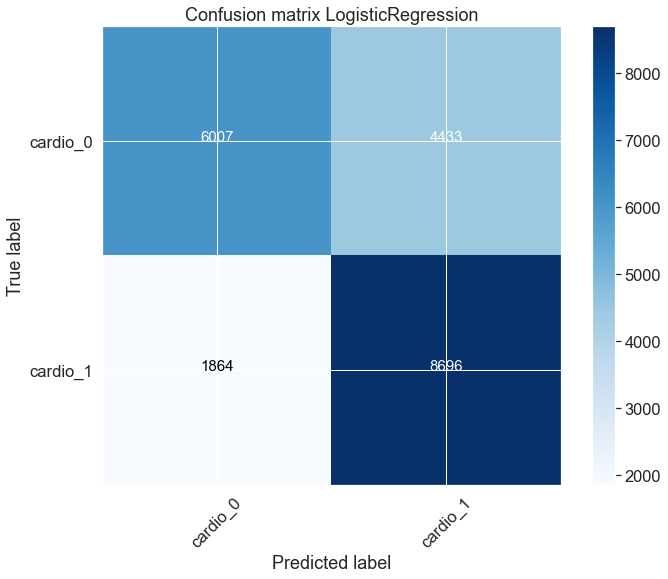

GradientBoostingClassifier
Confusion matrix, without normalization
[[5728 4712]
 [1596 8964]]


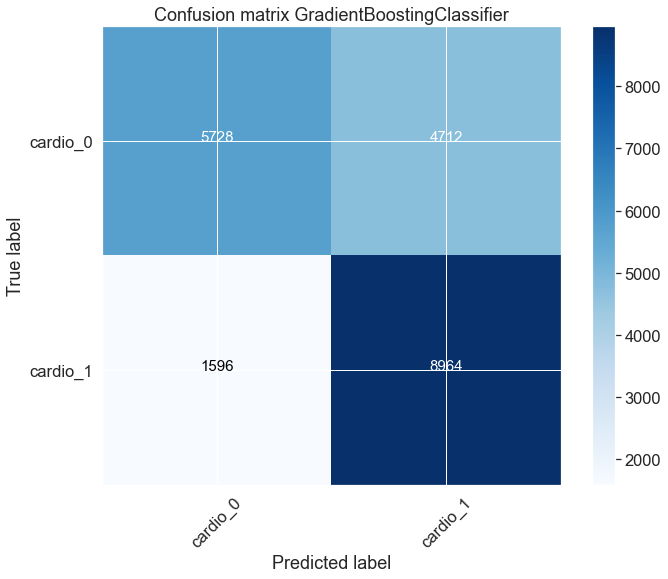

BaggingClassifier
Confusion matrix, without normalization
[[6118 4322]
 [2188 8372]]


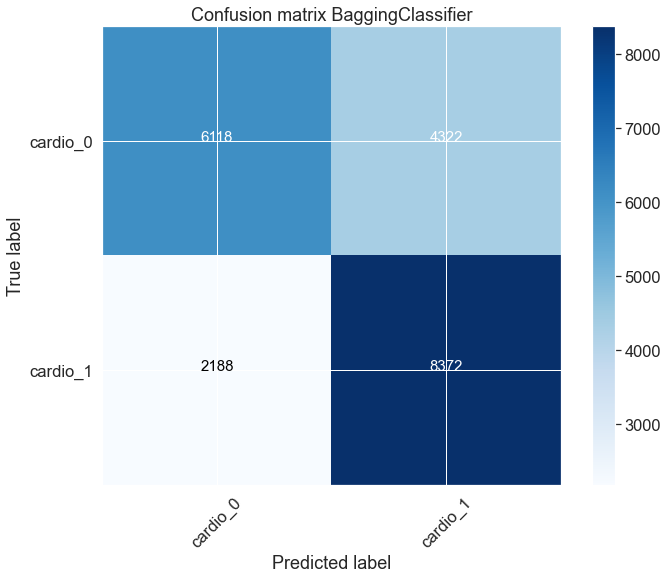

RandomForestClassifier
Confusion matrix, without normalization
[[5727 4713]
 [1583 8977]]


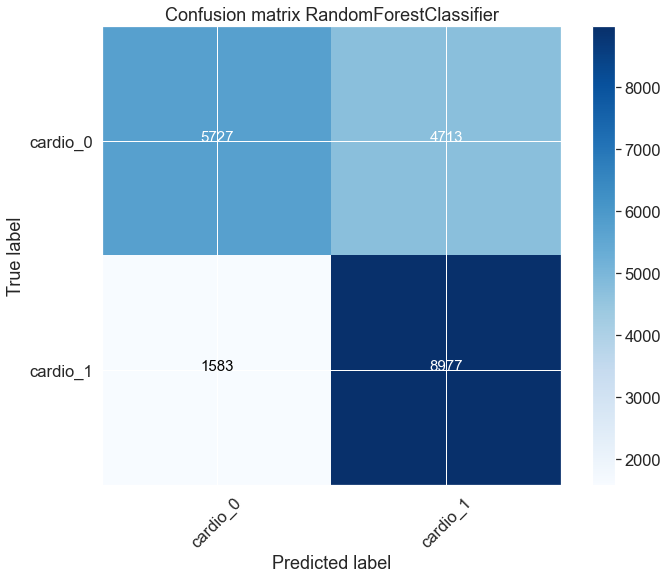

In [20]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = []
for indx, threshold in enumerate(data[:,0]):
    cnf_matrix.append(confusion_matrix(y_test, y_score[indx]>threshold))
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix[indx], classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix ' + labels[indx], label = labels[indx])
    #plt.savefig("conf_matrix.png")
    plt.show()
cnf_matrix = np.array((cnf_matrix))

#### Посчитаем FPR, TPR

In [21]:
for indx, matrix in enumerate(cnf_matrix):
    
    TN = matrix[0][0]
    FN = matrix[1][0]
    TP = matrix[1][1]
    FP = matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(labels[indx])
    print(f'TPR - {round(TPR,3)}, FPR - {round(FPR,3)}, TNR - {round(TNR,3)}')

LogisticRegression
TPR - 0.823, FPR - 0.425, TNR - 0.575
GradientBoostingClassifier
TPR - 0.849, FPR - 0.451, TNR - 0.549
BaggingClassifier
TPR - 0.793, FPR - 0.414, TNR - 0.586
RandomForestClassifier
TPR - 0.85, FPR - 0.451, TNR - 0.549


False Positive Rate  для RandomForestClassifier такой жекак и для GradientBoostingClassifier и хуже чем исходный вариант - LogisticRegression, но лучше True Positive Rate.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы, зато 85% имеющих заболевание точно узнают о нем.
